## 特征选择
特征选择决定了用哪个特征划分特征空间，也就是在哪个维度划分数据。

特征选择使用信息增益作为衡量标准。
$$g(D, A) = H(D) - H(D|A)$$

表示：由于特征A而使得数据集D的分类不确定度的减少程度。

In [1]:
import numpy as np

In [37]:
# 例5.1
    D = np.array([['青年', '否', '否', '一般', '否'],
                  ['青年', '否', '否', '好', '否'],
                  ['青年', '是', '否', '好', '是'],
                  ['青年', '是', '是', '一般', '是'],
                  ['青年', '否', '否', '一般', '否'],
                  ['中年', '否', '否', '一般', '否'],
                  ['中年', '否', '否', '好', '否'],
                  ['中年', '是', '是', '好', '是'],
                  ['中年', '否', '是', '非常好', '是'],
                  ['中年', '否', '是', '非常好', '是'],
                  ['老年', '否', '是', '非常好', '是'],
                  ['老年', '否', '是', '好', '是'],
                  ['老年', '是', '否', '好', '是'],
                  ['老年', '是', '否', '非常好', '是'],
                  ['老年', '否', '否', '一般', '否'],
                  ['青年', '否', '否', '一般', '是']])

In [38]:
X = D[:, :-1]
y = D[:, -1]

In [39]:
X

array([['青年', '否', '否', '一般'],
       ['青年', '否', '否', '好'],
       ['青年', '是', '否', '好'],
       ['青年', '是', '是', '一般'],
       ['青年', '否', '否', '一般'],
       ['中年', '否', '否', '一般'],
       ['中年', '否', '否', '好'],
       ['中年', '是', '是', '好'],
       ['中年', '否', '是', '非常好'],
       ['中年', '否', '是', '非常好'],
       ['老年', '否', '是', '非常好'],
       ['老年', '否', '是', '好'],
       ['老年', '是', '否', '好'],
       ['老年', '是', '否', '非常好'],
       ['老年', '否', '否', '一般'],
       ['青年', '否', '否', '一般']], dtype='<U3')

In [40]:
y

array(['否', '否', '是', '是', '否', '否', '否', '是', '是', '是', '是', '是', '是',
       '是', '否', '是'], dtype='<U3')

In [41]:
from collections import Counter
y_conter = Counter(y)
y_conter

Counter({'否': 6, '是': 10})

In [42]:
y_conter.most_common(1)[0][0]

'是'

In [43]:
y_conter.values()

dict_values([6, 10])

In [44]:
from collections import Counter
def cal_empirical_entropy(y):
    '''计算经验熵'''
    ret = 0.0
    y_counter = Counter(y)
    # v : |C_k|
    # len(y): |D|
    for v in y_counter.values():          
        ret += (v / len(y)) * np.log2(v / len(y))
    
    return -ret

In [45]:
cal_empirical_entropy(y)

0.954434002924965

In [47]:
def cal_conditional_entropy(X, y, dim, cal_empirical_entropy_=None):
    '''计算条件熵'''
    ret = 0.0
    x_counter = Counter(X[:, dim])
    # x_i: X的第dim个维度的第i个特征值
    # x_c: x_i的统计结果
    if cal_empirical_entropy_ is not None:
        for x_i, x_c in zip(x_counter.keys(), x_counter.values()):
            y_k = y[X[:, dim] == x_i]
            ret += (x_c / len(y)) * cal_empirical_entropy_(y_k)
    else:
        for x_c in x_counter.values():
            ret -= (x_c / len(y)) * np.log2(x_c / len(y))
            
    return ret

In [48]:
cal_conditional_entropy(X, y, 0)

1.579434002924965

In [49]:
def cal_information_gan(X, y, dim):
    '''计算信息增益'''
    return cal_empirical_entropy(y) - cal_conditional_entropy(X, y, dim, cal_empirical_entropy)

In [50]:
def cal_information_gan_ratio(X, y, dim):
    gan = cal_information_gan(X, y, dim)
    h = cal_conditional_entropy(X, y, dim)

    # 处理 h == 0
    if abs(h) < 1e-9:
        return 0
    return gan / h

In [51]:
cal_information_gan(X, y, 0)

0.0504094125055804

In [52]:
cal_information_gan(X, y, 1)

0.2710382325345575

In [53]:
cal_information_gan(X, y, 2)

0.34758988139079716

In [54]:
cal_information_gan(X, y, 3)

0.2657121273840979

## 决策树的生成

由于C4.5和ID3过程一致，所以采用C4.5算法，使用信息增益比实现，避免直接使用信息增益划分训练集时，偏向选择取值较多的特征的问题

In [55]:
class Node:
    def __init__(self):
        self.sub = {}  # 子树
        self.leaf = None  # 叶节点，最终的预测类别
        self.condition = lambda x_i: x_i  # 子树的方向
        self.sample_classes = []  # 该节点包含的样本类别
        self.split_dim = None  # 划分维度

In [56]:
n_leaf = 0 # 记录一下一共有多少叶节点

In [57]:
def build_tree(X, y, epsilon):
    global n_leaf
    assert len(X) == len(y), "X and y len error"

    node = Node()  # 创建树的根节点
    node.sample_classes = y  # 对样本类别做一个保存
    y_counter = Counter(y)  # 对 label做一个统计

    # 1. 判断所有实例是否属于同一类， 设置node为点节点数
    # 2. 特征集是否是空集， 设置node为点节点数
    if len(y_counter) == 1 or len(X) == 0:
        node.leaf = y_counter.most_common(1)[0][0]
        n_leaf += 1
    else:
        # 3. 计算各个维度的信息增益比，找到最好的划分维度
        best_ratio = float('-inf')
        best_dim = None
        for dim in range(X.shape[-1]):

            gan_ratio = cal_information_gan_ratio(X, y, dim)
            if gan_ratio > best_ratio:
                best_ratio = gan_ratio
                best_dim = dim

        node.split_dim = best_dim

        # 4. 如果best_ratio 小于ε， 设置T为点节点数
        if best_ratio < epsilon:
            node.leaf = y_counter.most_common(1)[0][0]
            n_leaf += 1
        else:
            x_counter = Counter(X[:, best_dim])

            # 5. 对best_dim下的每个特征值，将D划分为子空间，并构建子节点
            for x_i in x_counter:
                sub_X = X[X[:, best_dim] == x_i]
                sub_y = y[X[:, best_dim] == x_i]
                index = node.condition(x_i)
                node.sub[index] = build_tree(sub_X, sub_y, epsilon)

    return node

In [58]:
t = build_tree(X, y, 1e-2)

In [59]:
t.leaf

In [60]:
t.sub

{'否': <__main__.Node at 0x1d7c20bec50>, '是': <__main__.Node at 0x1d7c215b240>}

In [61]:
n_leaf

6

## 决策树的剪枝

In [75]:
def loss_function(samples_n, entropy, alpha, diff_leaf):
    global n_leaf
    return np.sum(np.array(samples_n) * np.array(entropy)) + alpha * (n_leaf - diff_leaf)

In [74]:
def pruning_tree(node, alpha):
    global n_leaf
    # 计算节点熵
    entropy = cal_empirical_entropy(node.sample_classes)
    # 该节点是叶节点
    if node.leaf is not None:
        return 1, entropy, node.leaf
    # 否则遍历子节点
    else:
        n_sub_samples = 0  # 子节点的个数
        n_sub_sample_classes = []  # 子节点的样本的类别
        sub_node_entropy = []  # 子节点的先验熵
        sub_leaf_class = []  # 子节点叶子的存放的类别
        for index in node.sub:
            sub_node = node.sub[index]
            i, e, l = pruning_tree(sub_node, alpha)
            n_sub_samples += i
            n_sub_sample_classes.append(len(sub_node.sample_classes))
            sub_node_entropy.append(e)
            sub_leaf_class.append(l)

        # 找到一组叶节点
        if n_sub_samples == len(node.sub):
            # 比较损失函数
            b_loss = loss_function(n_sub_sample_classes, sub_node_entropy, alpha, 0)
            a_loss = loss_function(len(node.sample_classes), entropy, alpha, n_sub_samples)
            if a_loss < b_loss:
                c = Counter(sub_leaf_class)
                node.sub.clear()  # 清理子树
                node.leaf = c.most_common(1)[0][0]  # 设置叶节点
                n_leaf -= (n_sub_samples - 1)  # 叶子的数量减少 子节点的个数 + 1 个

                return 1, entropy, node.leaf

        return 0, entropy, node.leaf

In [76]:
pruning_tree(t, 0.5)

(0, 0.954434002924965, None)

In [77]:
n_leaf

4

**以上算法实现未考虑离连续特征的处理**

## CRAT
### 回归树

In [79]:
from cart import CartRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

boston = datasets.load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666)
dt_reg = CartRegression(min_samples_leaf=3)
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))

dt_reg_2 = DecisionTreeRegressor()
dt_reg_2.fit(X_train, y_train)
y_pred_2 = dt_reg_2.predict(X_test)
print(mean_squared_error(y_test, y_pred_2))

28.254758606067107
29.481417322834645


### 分类树

C:\Users\ANG\AppData\Local\conda\conda\envs\ml\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


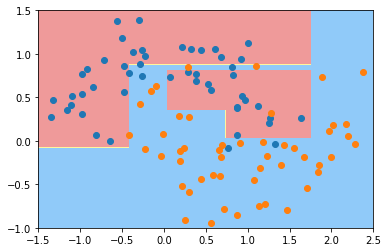

In [81]:
from cart import CartClassifier, plot_decision_boundary
import matplotlib.pyplot as plt
%matplotlib inline

X, y = datasets.make_moons(noise=0.25, random_state=666)
dt_clf = CartClassifier()
dt_clf.fit(X, y)

plot_decision_boundary(dt_clf, axis=[-1.5, 2.5, -1.0, 1.5])
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])
plt.show()